# Beta Chain Model Comparisons

## Setup

In [2]:
import os
from pathlib import Path
import sys

if '__project_dir__' not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [3]:
import json
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn

seaborn.set_theme()
seaborn.set_style('darkgrid')
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [4]:
BENCHMARKING_PARENT_DIR = Path('benchmarks_beta')

In [5]:
metric_dicts = []

for model in BENCHMARKING_PARENT_DIR.iterdir():
    with open(model/'summary.json', 'r') as f:
        metric_dicts.append(json.load(f))

In [6]:
def clean_plot(metrics, models):
    embedding_info = metrics.loc[models]
    embedding_info_plot = embedding_info.plot(kind='bar', legend=False)
    plt.ylabel("average precision")
    plt.xlabel("model name")
    return embedding_info_plot

In [7]:
def list_censoring_variants(base_name, censoring_type):
    return [f"{base_name} +ACL ({censoring_type} {level})" for level in ("0.01", "0.05", "0.10", "0.15", "0.20")]

In [8]:
def plot_pr_curve(ax, model_name, dataset, color):
    precisions = np.load(BENCHMARKING_PARENT_DIR/model_name/f"{dataset}_precisions.npy")
    recalls = np.load(BENCHMARKING_PARENT_DIR/model_name/f"{dataset}_recalls.npy")

    ax.step(recalls, precisions, c=color, label=model_name)

In [9]:
def knn_plot(metrics, models):
    embedding_info = metrics.loc[models]
    embedding_info_plot = embedding_info.plot(kind='bar')
    plt.ylabel('knn score')
    plt.xlabel('model name')
    plt.axhline(1/29, color='tab:grey', linestyle='dashed')
    seaborn.move_legend(embedding_info_plot, 'upper left', bbox_to_anchor=(1, 1))
    embedding_info_plot.set_ylim(0,0.3)
    return embedding_info_plot

## Average Precisions

In [10]:
vdjdb_avg_precisions = {mdict["model_name"]: mdict["vdjdb"]["avg_precision"] for mdict in metric_dicts}
vdjdb_avg_precisions = pd.DataFrame.from_dict(vdjdb_avg_precisions, orient="index")
vdjdb_avg_precisions = vdjdb_avg_precisions.sort_values(by=0)

[Text(0, 0, 'BCDRBERT +ACL'),
 Text(1, 0, 'BCDRBERT +ACL (cns 0.01)'),
 Text(2, 0, 'BCDRBERT +ACL (cns 0.05)'),
 Text(3, 0, 'BCDRBERT +ACL (cns 0.10)'),
 Text(4, 0, 'BCDRBERT +ACL (cns 0.15)'),
 Text(5, 0, 'BCDRBERT +ACL (cns 0.20)')]

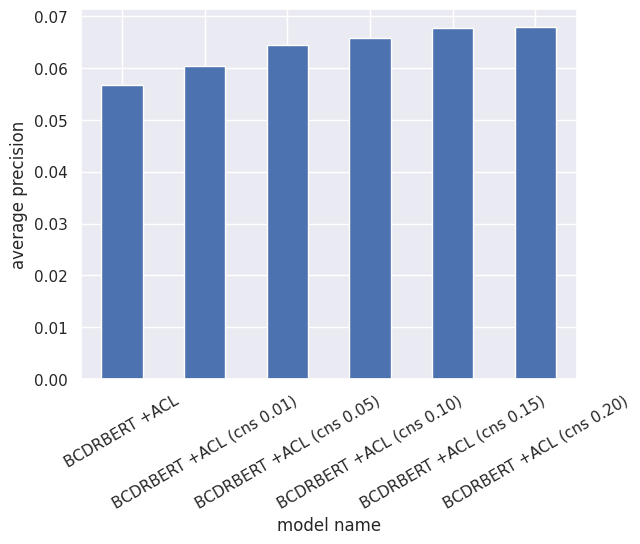

In [11]:
ax = clean_plot(vdjdb_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERT", "cns")])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

[Text(0, 0, 'BCDRBERT +ACL'),
 Text(1, 0, 'BCDRBERT +ACL (cdrcns 0.01)'),
 Text(2, 0, 'BCDRBERT +ACL (cdrcns 0.05)'),
 Text(3, 0, 'BCDRBERT +ACL (cdrcns 0.10)'),
 Text(4, 0, 'BCDRBERT +ACL (cdrcns 0.15)'),
 Text(5, 0, 'BCDRBERT +ACL (cdrcns 0.20)')]

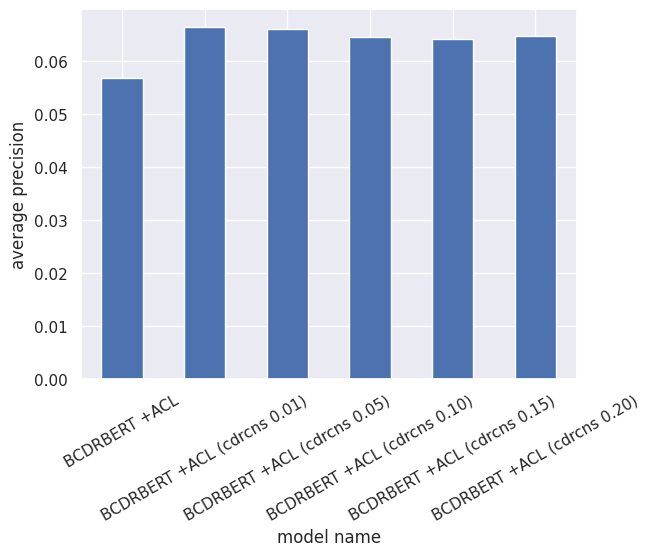

In [12]:
ax = clean_plot(vdjdb_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERT", "cdrcns")])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

## PR curves

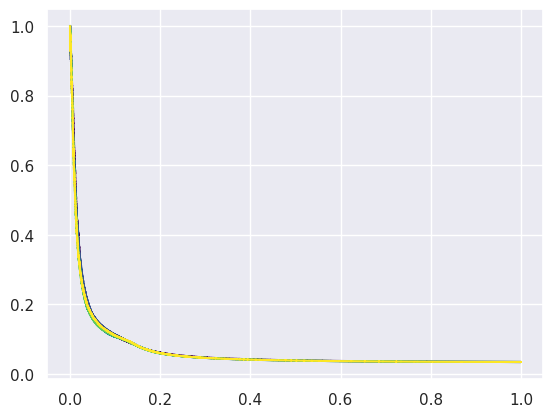

In [13]:
fig, ax = plt.subplots()

models = list_censoring_variants("BCDRBERT", "cdrcns")
colors = pl.cm.viridis(np.linspace(0, 1, len(models)))

for i, model in enumerate(models):
    plot_pr_curve(ax, model, "vdjdb", colors[i])

#ax.set_xlim(0, 0.05)
plt.show()

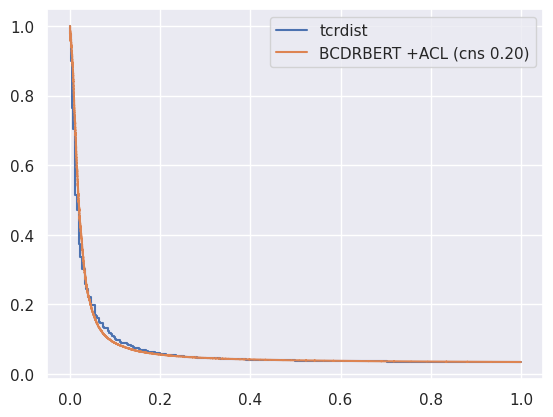

In [24]:
fig, ax = plt.subplots()

models = ["tcrdist", "BCDRBERT +ACL (cns 0.20)"]

for i, model in enumerate(models):
    plot_pr_curve(ax, model, "vdjdb", f"C{i}")

#ax.set_xlim(0, 0.2)
plt.legend()
plt.show()

## k-NN Scores

In [15]:
knn_scores = {mdict['model_name']: mdict['vdjdb']['knn_scores'] for mdict in metric_dicts}
knn_scores = pd.DataFrame.from_dict(knn_scores, orient='index')
knn_scores = knn_scores.sort_values(by='5')
knn_scores.columns = knn_scores.columns.map(lambda x: f'k={x}')

In [16]:
knn_scores

,k=5,k=10,k=50,k=100
BCDR3BERT (-pos),0.118621,0.118621,0.110345,0.111379
BCDR3BERT (rel pos),0.145862,0.150345,0.139310,0.133103
BCDR3BERT (BD pos),0.146897,0.151034,0.142759,0.138621
BCDR3BERT,0.156897,0.161724,0.146207,0.142414
BCDR3Levenshtein,0.182759,0.180690,0.162414,0.151724
BVCDR3BERT,0.189310,0.192759,0.174828,0.159655
BCDRBERT,0.212414,0.217586,0.220690,0.207931
BCDRBERT +ACL,0.241379,0.255172,0.228966,0.225862
BCDRBERT +ACL (cdrcns 0.01),0.247241,0.254483,0.230000,0.219655
BCDRBERT +ACL (cdrcns 0.15),0.247586,0.252069,0.221724,0.211379


[Text(0, 0, 'BCDR3Levenshtein'), Text(1, 0, 'tcrdist')]

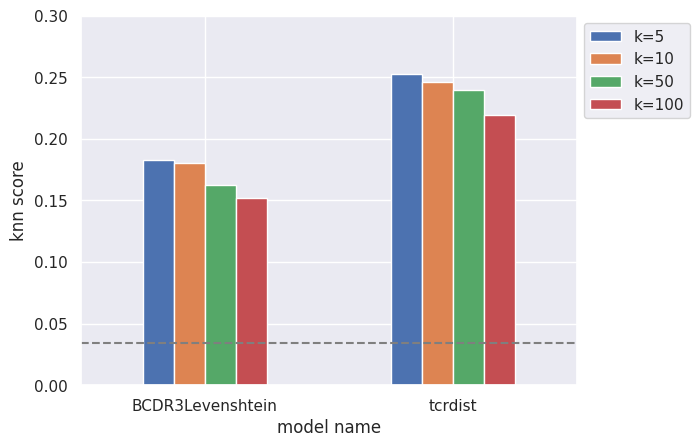

In [17]:
ax = knn_plot(knn_scores, ['BCDR3Levenshtein', "tcrdist"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

[Text(0, 0, 'BCDR3BERT'),
 Text(1, 0, 'BCDR3BERT (-pos)'),
 Text(2, 0, 'BCDR3BERT (BD pos)'),
 Text(3, 0, 'BCDR3BERT (rel pos)')]

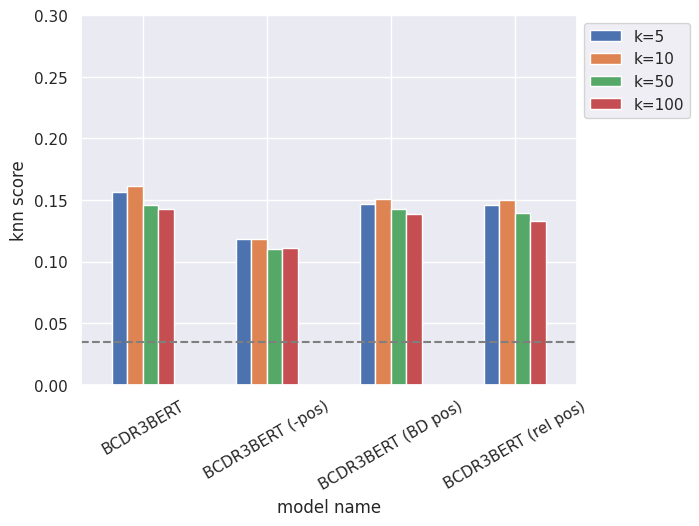

In [18]:
ax = knn_plot(knn_scores, ['BCDR3BERT', "BCDR3BERT (-pos)", "BCDR3BERT (BD pos)", "BCDR3BERT (rel pos)"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

[Text(0, 0, 'BVCDR3BERT'), Text(1, 0, 'BCDRBERT')]

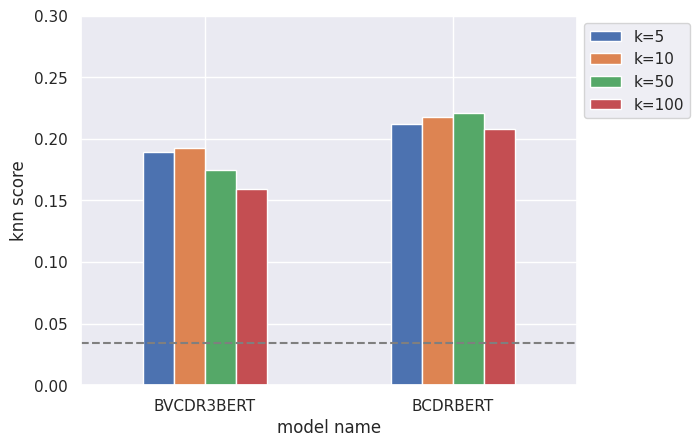

In [19]:
ax = knn_plot(knn_scores, ['BVCDR3BERT', 'BCDRBERT'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

### Does it learn with autocontrastive learning?

[Text(0, 0, 'BCDRBERT +ACL')]

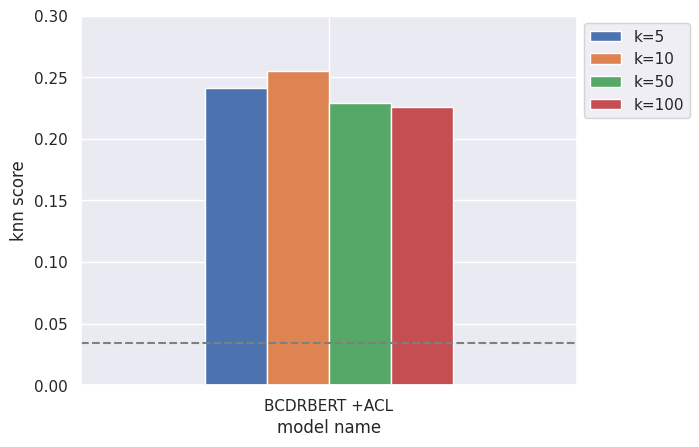

In [20]:
ax = knn_plot(knn_scores, ['BCDRBERT +ACL'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

### Does autocontrastive learning work better with censoring?

[Text(0, 0, 'BCDRBERT +ACL (cns 0.01)'),
 Text(1, 0, 'BCDRBERT +ACL (cns 0.05)'),
 Text(2, 0, 'BCDRBERT +ACL (cns 0.10)'),
 Text(3, 0, 'BCDRBERT +ACL (cns 0.15)'),
 Text(4, 0, 'BCDRBERT +ACL (cns 0.20)')]

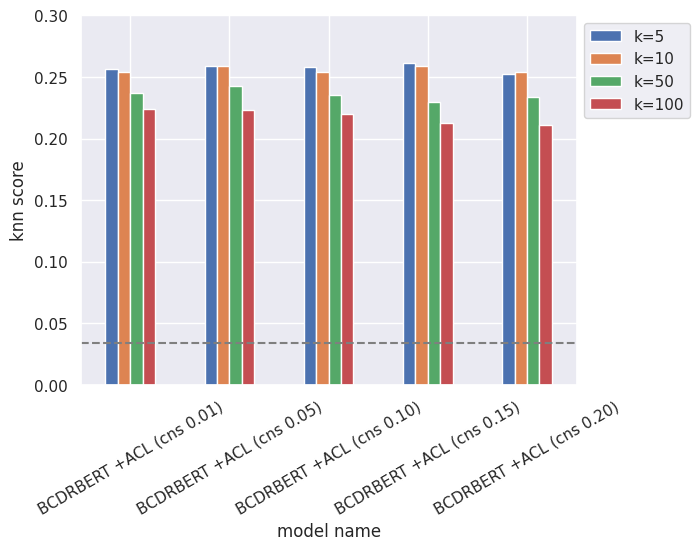

In [21]:
ax = knn_plot(knn_scores, list_censoring_variants("BCDRBERT", "cns"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

[Text(0, 0, 'BCDRBERT +ACL (cdrcns 0.01)'),
 Text(1, 0, 'BCDRBERT +ACL (cdrcns 0.05)'),
 Text(2, 0, 'BCDRBERT +ACL (cdrcns 0.10)'),
 Text(3, 0, 'BCDRBERT +ACL (cdrcns 0.15)'),
 Text(4, 0, 'BCDRBERT +ACL (cdrcns 0.20)')]

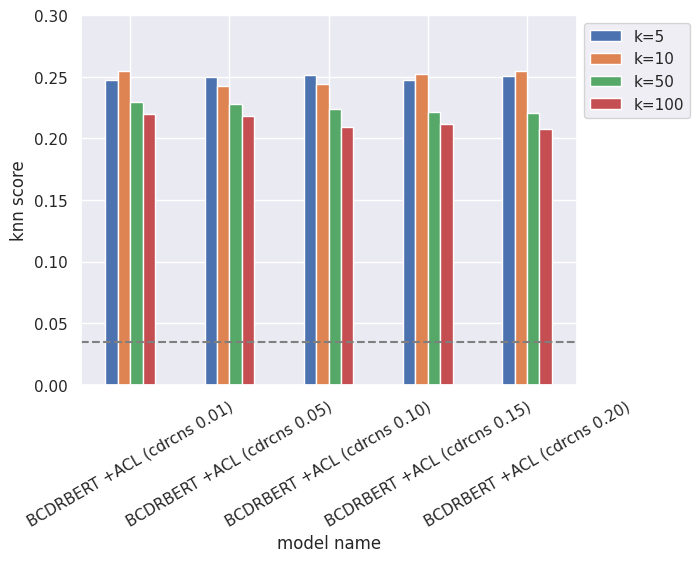

In [22]:
ax = knn_plot(knn_scores, list_censoring_variants("BCDRBERT", "cdrcns"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

### VS tcrdist

[Text(0, 0, 'tcrdist'), Text(1, 0, 'BCDRBERT +ACL (cns 0.15)')]

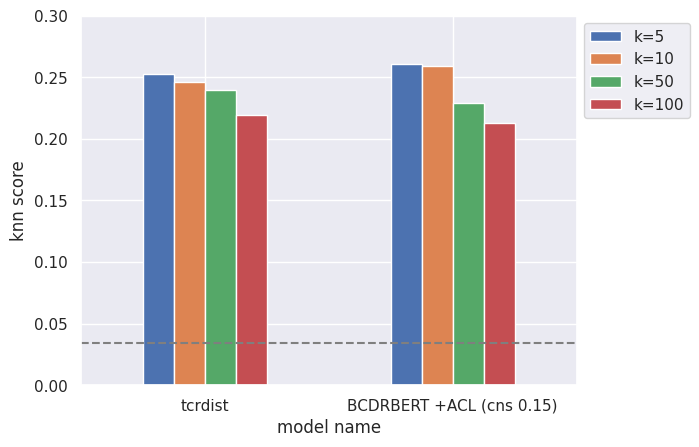

In [23]:
ax = knn_plot(knn_scores, ['tcrdist', 'BCDRBERT +ACL (cns 0.15)'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)